In [1]:
!git lfs install
!git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M
# rename to a valid python module name
!mv Prithvi-100M prithvi

Git LFS initialized.
Cloning into 'Prithvi-100M'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 199 (delta 21), reused 0 (delta 0), pack-reused 150 (from 1)
Receiving objects: 100% (199/199), 49.19 KiB | 8.20 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Filtering content: 100% (6/6), 875.97 MiB | 76.13 MiB/s, done.


In [2]:
%cd /content/prithvi

/content/prithvi


In [3]:
import torch
import torch.nn as nn
import numpy as np
# from prithvi.Prithvi import MaskedAutoencoderViT
from prithvi.prithvi_mae import PrithviMAE
import yaml

class PrithviSegmentationModel(nn.Module):
    def __init__(self, ckpt_path, cfg_path, img_size=224, num_classes=2):
        super(PrithviSegmentationModel, self).__init__()

        model_cfg_path = cfg_path
        with open(model_cfg_path) as f:
            model_config = yaml.safe_load(f)

        model_args, train_args = model_config["model_args"], model_config["train_params"]
        model_args["num_frames"] = 1

        self.encoder = PrithviMAE(**model_args)
        weights_path = ckpt_path
        checkpoint = torch.load(weights_path, map_location="cpu")
        del checkpoint['encoder.pos_embed']
        del checkpoint['decoder.decoder_pos_embed']
        self.encoder.load_state_dict(checkpoint, strict=False)


        # Define the upscaling blocks and segmentation head
        self.embed_dims = [768 // (2 ** i) for i in range(5)]

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(6, num_classes, kernel_size=1)
        )


    def forward(self, x):
        # Pass through the encoder
        _, features, _ = self.encoder.forward(x, mask_ratio=0.0)
        reshaped_features =self.encoder.unpatchify(features).squeeze(2)

        # Pass through the segmentation head
        y_pred = self.segmentation_head(reshaped_features)
        return y_pred

# Example usage
ckpt_path = CFG_PATH = "/content/prithvi/Prithvi_100M.pt"
cfg_path = CKPT_PATH = "/content/prithvi/config.yaml"
model = PrithviSegmentationModel(ckpt_path=ckpt_path, cfg_path=cfg_path)
x = torch.rand(3, 6, 1, 224, 224)  # (b, c, h, w)
y_pred = model(x)  # (b, num_classes, h, w)
y_pred.shape

torch.Size([3, 2, 224, 224])

In [4]:
# Original Model Code

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import Block
from timm.models.layers import to_2tuple

import numpy as np

from einops import rearrange

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_3d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: 3d tuple of grid size: t, h, w
    return:
    pos_embed: L, D
    """

    assert embed_dim % 16 == 0

    t_size, h_size, w_size = grid_size

    w_embed_dim = embed_dim // 16 * 6
    h_embed_dim = embed_dim // 16 * 6
    t_embed_dim = embed_dim // 16 * 4

    w_pos_embed = get_1d_sincos_pos_embed_from_grid(w_embed_dim, np.arange(w_size))
    h_pos_embed = get_1d_sincos_pos_embed_from_grid(h_embed_dim, np.arange(h_size))
    t_pos_embed = get_1d_sincos_pos_embed_from_grid(t_embed_dim, np.arange(t_size))

    w_pos_embed = np.tile(w_pos_embed, (t_size * h_size, 1))
    h_pos_embed = np.tile(np.repeat(h_pos_embed, w_size, axis=0), (t_size, 1))
    t_pos_embed = np.repeat(t_pos_embed, h_size * w_size, axis=0)

    pos_embed = np.concatenate((w_pos_embed, h_pos_embed, t_pos_embed), axis=1)

    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


class PatchEmbed(nn.Module):
    """ Frames of 2D Images to Patch Embedding
    The 3D version of timm.models.vision_transformer.PatchEmbed
    """
    def __init__(
            self,
            img_size=224,
            patch_size=16,
            num_frames=3,
            tubelet_size=1,
            in_chans=3,
            embed_dim=768,
            norm_layer=None,
            flatten=True,
            bias=True,
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_frames = num_frames
        self.tubelet_size = tubelet_size
        self.grid_size = (num_frames // tubelet_size, img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1] * self.grid_size[2]
        self.flatten = flatten

        self.proj = nn.Conv3d(in_chans, embed_dim,
                              kernel_size=(tubelet_size, patch_size[0], patch_size[1]),
                              stride=(tubelet_size, patch_size[0], patch_size[1]), bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, T, H, W = x.shape
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # B,C,T,H,W -> B,C,L -> B,L,C
        x = self.norm(x)
        return x


class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16,
                 num_frames=3, tubelet_size=1,
                 in_chans=3, embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size,num_frames, tubelet_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, tubelet_size * patch_size * patch_size * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_3d_sincos_pos_embed(self.pos_embed.shape[-1], self.patch_embed.grid_size, cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_3d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], self.patch_embed.grid_size, cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: B, C, T, H, W
        x: B, L, D
        """
        p = self.patch_embed.patch_size[0]
        tub = self.patch_embed.tubelet_size
        x = rearrange(imgs, 'b c (t tub) (h p) (w q) -> b (t h w) (tub p q c)', tub=tub, p=p, q=p)

        return x

    def unpatchify(self, x):
        """
        x: B, L, D
        imgs: B, C, T, H, W
        """
        p = self.patch_embed.patch_size[0]
        num_p = self.patch_embed.img_size[0] // p
        tub = self.patch_embed.tubelet_size
        imgs = rearrange(x, 'b (t h w) (tub p q c) -> b c (t tub) (h p) (w q)', h=num_p, w=num_p, tub=tub, p=p, q=p)
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: B, C, T, H, W
        target: B, L, D
        pred: B, L, D
        mask: B, L. 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
import torch
import torch.nn as nn
import numpy as np
# from prithvi.Prithvi import MaskedAutoencoderViT
# from prithvi.prithvi_mae import PrithviMAE
import yaml


class PrithviSegmentationModel(nn.Module):
    def __init__(self, ckpt_path, cfg_path, img_size=224, num_classes=2):
        super(PrithviSegmentationModel, self).__init__()

        model_cfg_path = cfg_path
        with open(model_cfg_path) as f:
            model_config = yaml.safe_load(f)

        model_args, train_args = model_config["model_args"], model_config["train_params"]
        model_args["num_frames"] = 1

        self.encoder = MaskedAutoencoderViT(**model_args)
        weights_path = ckpt_path

        # Define the upscaling blocks and segmentation head
        self.embed_dims = [768 // (2 ** i) for i in range(5)]

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(6, num_classes, kernel_size=1)
        )


    def forward(self, x):
        # Pass through the encoder
        _, features, _ = self.encoder.forward(x, mask_ratio=0.0)
        reshaped_features =self.encoder.unpatchify(features).squeeze(2)

        # Pass through the segmentation head
        y_pred = self.segmentation_head(reshaped_features)
        return y_pred

# Example usage
ckpt_path = CFG_PATH = "/content/prithvi/Prithvi_100M.pt"
cfg_path = CKPT_PATH = "/content/prithvi/config.yaml"
model = PrithviSegmentationModel(ckpt_path=ckpt_path, cfg_path=cfg_path)
x = torch.rand(3, 6, 1, 224, 224)  # (b, c, h, w)
y_pred = model(x)  # (b, num_classes, h, w)
y_pred.shape

torch.Size([3, 2, 224, 224])

# Training

In [9]:
def input_pipeline(filename, batch_size, is_shuffle=True, is_train=True, is_repeat=True):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([400*400*4], dtype=tf.int64),
        'label': tf.io.FixedLenFeature([400*400*1], dtype=tf.int64),
    }

    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(feature_dict['image_raw'], [400, 400, 4])
        image = tf.cast(image, tf.float32)

        image = image/10000

        label = tf.reshape(feature_dict['label'], [400, 400, 1])
        label = tf.cast(label, tf.float32)

        image_label = tf.concat([image, label], axis=-1)
        image_label = tf.image.resize(image_label, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        if is_train:
            image_label = tf.image.rot90(image_label, tf.random.uniform([], 0, 5, dtype=tf.int32))
            image_label = tf.image.random_flip_left_right(image_label)
            image_label = tf.image.random_flip_up_down(image_label)

        image = image_label[:, :, :4]
        image = tf.concat([image, tf.zeros([224, 224, 2])], axis=-1)

        label = image_label[:, :, -1]
        label = tf.cast(label, tf.int64)

        image = tf.transpose(image, perm=[2, 0, 1])

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    if is_repeat:
        dataset = dataset.repeat()
    dataset = dataset.map(_parse_function)
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    batch = dataset.batch(batch_size=batch_size)
    return batch

In [8]:
import os
folder = ['/content/drive/MyDrive/ice_cloud/l8ps_ds_2', '/content/drive/MyDrive/ice_cloud/l8ps_ds_3',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_4', '/content/drive/MyDrive/ice_cloud/l8ps_ds_5', '/content/drive/MyDrive/ice_cloud/l8ps_ds_6']
filenames = [os.path.join(folder[0], f) for f in os.listdir(folder[0]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[1], f) for f in os.listdir(folder[1]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[2], f) for f in os.listdir(folder[2]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[3]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[4], f) for f in os.listdir(folder[4]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]

filenames

['/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230308_212634_27_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230325_103503_19_240c.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230329_033637_63_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230402_144322_97_2402.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230417_072528_39_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094613_93_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094636_32_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230420_143108_00_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192205_75_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192219_98_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230503_122053_44_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230515_223754_57_240c.tfrecords',
 '/content/drive/MyDrive/ice

In [ ]:
import torch.optim as optim
import tensorflow as tf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_process():
    train_ds = input_pipeline(filenames, 8, is_repeat=False)

    old_acc = 0
    for i in range(20):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_idx, (images, labels) in enumerate(train_ds):
            images, labels = images.numpy(), labels.numpy()  # Step 1: Convert to NumPy
            images, labels = torch.tensor(images), torch.tensor(labels)  # Step 2: Convert to PyTorch tensors
            images, labels = images.to(device), labels.to(device)  # Step 3: Move to the specified device
            images = images[:, :, None, :, :]

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            correct_predictions_batch = (predicted == labels).sum().item()/((labels.size(0)*224*224))
            print(correct_predictions_batch)

        epoch_loss = running_loss/batch_idx
        epoch_accuracy = correct_predictions / (total_samples*224*224) * 100
        print(f"Epoch [{i+1}/{100}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        # torch.save(model.state_dict(), 'Prithvi.pth')

train_process()

# Test

In [13]:
checkpoint_path = '/content/drive/MyDrive/ice_cloud/github_code/Prithvi.pth'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint)
print("Weights loaded successfully.")

Weights loaded successfully.


In [14]:
from osgeo import gdal, osr

def tif2array(input_file):
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=int)

    for b in range(dataset.RasterCount):
        band = dataset.GetRasterBand(b + 1)
        image[:, :, b] = band.ReadAsArray()

    return image

def clip_center(img, clip_height, clip_width):
    """
    Clips the center part of the image.

    Parameters:
    - img: 2D or 3D NumPy array representing the image.
    - clip_height: Height of the central clip.
    - clip_width: Width of the central clip.

    Returns:
    - Clipped center part of the image as a NumPy array.
    """
    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Calculate the center coordinates
    center_y, center_x = img_height // 2, img_width // 2

    # Define the starting and ending points for the clipping
    start_y = max(center_y - clip_height // 2, 0)
    end_y = min(center_y + clip_height // 2, img_height)
    start_x = max(center_x - clip_width // 2, 0)
    end_x = min(center_x + clip_width // 2, img_width)

    # Return the clipped center part
    return img[start_y:end_y, start_x:end_x]

In [15]:
import os
folder_path = '/content/drive/MyDrive/ice_cloud/test_ds/dataset'
imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs.sort()

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds2/dataset'
imgs2 = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs2.sort()
imgs = imgs+imgs2
imgs

['/content/drive/MyDrive/ice_cloud/test_ds/dataset/2022-04-15_strip_5573346_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-08-31_strip_6747657_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-09_strip_6763305_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-14_strip_6774056_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-20_strip_6786319_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-21_strip_6788017_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-24_strip_6793653_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-27_strip_6800261_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-06_strip_6818915_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-08_strip_6823217_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-13_strip_6833728_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/202

/usr/local/lib/python3.12/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


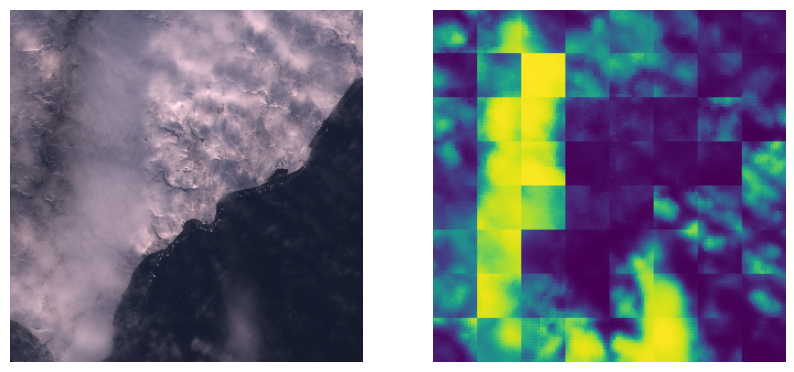

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for img_path in imgs[2:3]:
    img = tif2array(img_path)
    img = clip_center(img, 3200, 3200)
    img = tf.concat([img, tf.zeros([3200, 3200, 2])], axis=-1)
    img = img/10000

    img = tf.reshape(img, [1, 3200, 3200, 6])

    patch_size = 400
    stride = 400
    output_shape = (img.shape[1], img.shape[2])

    # Initialize an empty array for storing the full prediction
    full_prediction = np.zeros(output_shape)

    # Iterate over the image with a sliding window
    for i in range(0, img.shape[1], stride):
        for j in range(0, img.shape[2], stride):
            patch = img[:, i:i+patch_size, j:j+patch_size, :]

            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
                patch = tf.image.resize(patch, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                patch = tf.transpose(patch, perm=[0, 3, 1, 2])
                patch = torch.tensor(patch.numpy())
                patch = patch.to(device)
                patch = patch[:, :, None, :, :]
                pred = model(patch.float())
                pred = tf.transpose(pred.cpu().detach().numpy(), perm=[0, 2, 3, 1])
                pred = tf.nn.softmax(pred, axis=-1)
                pred = tf.image.resize(pred, [400, 400], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                full_prediction[i:i+patch_size, j:j+patch_size] = pred[0, :, :, 1]

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img[0, ::10, ::10, 2::-1], vmin=0, vmax=1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow((full_prediction), vmin=0, vmax=1)